In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from fastai.tabular.all import *
from multiprocessing import Pool
from sklearn.model_selection import KFold, GroupKFold
import lightgbm as lgb
from optiver_features import *
import pickle

In [3]:
df = pd.read_csv('../input/optiver-realized-volatility-prediction/train.csv')
time_ids = df.time_id.unique()

np.random.shuffle(time_ids)

splt = int(len(time_ids)*.7)
train_ids, test_ids = time_ids[:splt], time_ids[splt:]

len(train_ids), len(test_ids)

(2681, 1149)

In [4]:
len(df[df.time_id.isin(train_ids)]) / len(df)

0.7000083929387408

## Generate 5m dataset

In [10]:
book_feature_dict = {
    wap1: [np.mean, np.std],
    wap2: [np.mean, np.std],
    log_return1: [realized_volatility, np.mean, np.std],
    log_return2: [realized_volatility, np.mean, np.std],
    wap_balance: [np.mean, np.std],
    price_spread:[np.mean, np.std],
    bid_spread: [np.mean, np.std],
    ask_spread:[np.mean, np.std],
    total_volume:[np.mean, np.std],
    volume_imbalance:[np.mean, np.std]
}
trade_feature_dict = {
        log_return_price: [realized_volatility],
        'seconds_in_bucket':[np.size],
        'size':[np.sum],
        'order_count':[np.mean],
}
time_id_features=[]
time_id_aggregations = []
stock_id_features = []
stock_id_aggregations = [time_id_aggregations]
time_windows = [(0,300), (0,100), (100,200), (200,300)]

In [5]:
def generate_0_to_5():


    ofg = OptiverFeatureGenerator(book_feature_dict, trade_feature_dict, time_windows, time_id_features,time_id_aggregations, stock_id_features, stock_id_aggregations)
    train_df5m = ofg.generate_train_df()
    ofg_targ =OptiverFeatureGenerator({wap1:[], log_return1:[realized_volatility]}, {'seconds_in_bucket':[np.size]}, [(300,600)], [],[],[],[])
    targ_df = ofg_targ.generate_train_df()
    train_df5m.target = targ_df.log_return1_realized_volatility_300_600
    train_df5m.target = train_df5m.target.replace(0, train_df5m.target.mean())
    return train_df5m
    

In [6]:
%%time
train_df5m = generate_0_to_5()

CPU times: user 2.63 s, sys: 675 ms, total: 3.31 s
Wall time: 4min 32s


In [7]:

train_df5m.to_feather('train_5m.feather')

In [8]:
def rename_col(x):
    return x.replace('300', '600').replace('200', '500').replace('100', '400').replace('_0', '_300')
def rename_col_back(x):
    return x.replace('300', '0').replace('400', '100').replace('500', '200').replace('600', '300')

def generate_5_to_10():
    tw = [(x+300, y+300) for x,y in time_windows]
    time_id_feat = [rename_col(x) for x in time_id_features]
    stock_id_feat = [rename_col(x) for x in stock_id_features]
    ofg = OptiverFeatureGenerator(book_feature_dict, trade_feature_dict, tw, time_id_feat,time_id_aggregations, stock_id_feat, stock_id_aggregations)

    df = ofg.generate_train_df()
    df.columns = [rename_col_back(x) for x in df.columns]
    return df

In [11]:
train_df5_10m  = generate_5_to_10()
train_df5_10m.to_feather('train_5_10.feather')

## LGBM Baseline

In [12]:
def rmspe_np(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))
def feval_rmspe(y_pred, lgb_train):
    y_true = lgb_train.get_label()
    return 'RMSPE', rmspe_np(y_true, y_pred), False

def train_models(train):
    # Hyperparammeters (optimized)
    seed = 29
    params = {
        'learning_rate': 0.1,        
        'lambda_l1': 2,
        'lambda_l2': 7,
        'num_leaves': 800,
        'min_sum_hessian_in_leaf': 20,
        'feature_fraction': 0.8,
        'feature_fraction_bynode': 0.8,
        'bagging_fraction': 0.9,
        'bagging_freq': 42,
        'min_data_in_leaf': 700,
        'max_depth': 4,
        'seed': seed,
        'feature_fraction_seed': seed,
        'bagging_seed': seed,
        'drop_seed': seed,
        'data_random_seed': seed,
        'objective': 'rmse',
        'boosting': 'gbdt',
        'verbosity': -1,
        'n_jobs': -1,
    }   
    
    # Split features and target
    x = train.drop(['row_id', 'target', 'time_id'], axis = 1)
    y = train['target']
    # Transform stock id to a numeric value
    x['stock_id'] = x['stock_id'].astype(int)
    models =[]
    # Create out of folds array
    oof_predictions = np.zeros(x.shape[0])
    # Create a KFold object
    kfold = GroupKFold()
    # Iterate through each fold
    for fold, (trn_ind, val_ind) in enumerate(kfold.split(x, groups = train.time_id)):
        print(f'Training fold {fold + 1}')
        x_train, x_val = x.iloc[trn_ind], x.iloc[val_ind]
        y_train, y_val = y.iloc[trn_ind], y.iloc[val_ind]
        # Root mean squared percentage error weights
        train_weights = 1 / np.square(y_train)
        val_weights = 1 / np.square(y_val)
        train_dataset = lgb.Dataset(x_train, y_train, weight = train_weights, categorical_feature = ['stock_id'])
        val_dataset = lgb.Dataset(x_val, y_val, weight = val_weights, categorical_feature = ['stock_id'])
        model = lgb.train(params = params, 
                          train_set = train_dataset, 
                          valid_sets = [train_dataset, val_dataset], 
                          num_boost_round = 3000, 
                          early_stopping_rounds = 25, 
                          verbose_eval = 100,
                          feval = feval_rmspe)
        models.append(model)
        # Add predictions to the out of folds array
        oof_predictions[val_ind] = model.predict(x_val)
        # Predict the test set
        #test_predictions += model.predict(x_test) / 10
        
    rmspe_score = rmspe_np(y, oof_predictions)
    print(f'Our out of folds RMSPE is {rmspe_score}')
    # Return test predictions
    return models

In [13]:
_=train_models(train_df5m)

Training fold 1


/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.000352069	training's RMSPE: 0.240783	valid_1's rmse: 0.000365612	valid_1's RMSPE: 0.250465
[200]	training's rmse: 0.000343576	training's RMSPE: 0.234975	valid_1's rmse: 0.000362518	valid_1's RMSPE: 0.248345
[300]	training's rmse: 0.000338425	training's RMSPE: 0.231452	valid_1's rmse: 0.000361348	valid_1's RMSPE: 0.247543
[400]	training's rmse: 0.000334341	training's RMSPE: 0.228658	valid_1's rmse: 0.000360762	valid_1's RMSPE: 0.247142
[500]	training's rmse: 0.000331185	training's RMSPE: 0.2265	valid_1's rmse: 0.000360449	valid_1's RMSPE: 0.246928
Early stopping, best iteration is:
[515]	training's rmse: 0.00033076	training's RMSPE: 0.22621	valid_1's rmse: 0.00036034	valid_1's RMSPE: 0.246853
Training fold 2


/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.000352568	training's RMSPE: 0.240627	valid_1's rmse: 0.000371483	valid_1's RMSPE: 0.256567
[200]	training's rmse: 0.000343888	training's RMSPE: 0.234703	valid_1's rmse: 0.000368845	valid_1's RMSPE: 0.254745
Early stopping, best iteration is:
[196]	training's rmse: 0.000344179	training's RMSPE: 0.234902	valid_1's rmse: 0.000368708	valid_1's RMSPE: 0.25465
Training fold 3


/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.000353414	training's RMSPE: 0.241643	valid_1's rmse: 0.000363559	valid_1's RMSPE: 0.249303
[200]	training's rmse: 0.000344893	training's RMSPE: 0.235817	valid_1's rmse: 0.000360593	valid_1's RMSPE: 0.24727
[300]	training's rmse: 0.00033976	training's RMSPE: 0.232307	valid_1's rmse: 0.000359688	valid_1's RMSPE: 0.246649
[400]	training's rmse: 0.000335828	training's RMSPE: 0.229619	valid_1's rmse: 0.000359368	valid_1's RMSPE: 0.24643
Early stopping, best iteration is:
[382]	training's rmse: 0.000336452	training's RMSPE: 0.230046	valid_1's rmse: 0.000359285	valid_1's RMSPE: 0.246373
Training fold 4


/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.00035168	training's RMSPE: 0.241638	valid_1's rmse: 0.000388214	valid_1's RMSPE: 0.260948
[200]	training's rmse: 0.000343253	training's RMSPE: 0.235848	valid_1's rmse: 0.000384083	valid_1's RMSPE: 0.25817
Early stopping, best iteration is:
[252]	training's rmse: 0.000340419	training's RMSPE: 0.233901	valid_1's rmse: 0.000382195	valid_1's RMSPE: 0.256901
Training fold 5


/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.000353504	training's RMSPE: 0.241598	valid_1's rmse: 0.000393869	valid_1's RMSPE: 0.27056
Early stopping, best iteration is:
[86]	training's rmse: 0.000355309	training's RMSPE: 0.242832	valid_1's rmse: 0.000393114	valid_1's RMSPE: 0.270042
Our out of folds RMSPE is 0.2551091979883696


## Learning embeddings

In [14]:
cont_nn,cat_nn = cont_cat_split(train_df5m, max_card=9000, dep_var='target')


cat_nn = ['time_id', 'stock_id']

In [15]:

procs_nn = [Categorify, FillMissing,Normalize]

splits = RandomSplitter()(train_df5m)

dls = TabularPandas(train_df5m, procs_nn, cat_nn, cont_nn,
                      splits=splits, 
                       
                      y_names='target').dataloaders(1024)

In [16]:
def rmspe(preds, targs):
    x = (targs-preds)/targs
    return (x**2).mean().sqrt()

config={'lin_first':True, 'ps':[.5,.2,0], 'embed_p':.25, }
learn = tabular_learner(dls, y_range=(0,.1), layers=[100,50,20], emb_szs={'stock_id':10, 'time_id':10}, 
                        n_out=1, loss_func = rmspe, metrics=AccumMetric(rmspe), config=config)

In [17]:
learn.fit_one_cycle(20, 5e-3)

epoch,train_loss,valid_loss,rmspe,time
0,13.305634,10.301177,10.576388,00:12
1,1.708793,0.988159,1.528719,00:05
2,0.330817,0.270669,0.273019,00:05
3,0.284078,0.260173,0.262377,00:04
4,0.272524,0.248375,0.252715,00:05
5,0.272001,0.264082,0.265079,00:05
6,0.274739,0.245683,0.247233,00:04
7,0.263808,0.238444,0.240142,00:05
8,0.253014,0.233194,0.235285,00:05
9,0.264505,0.249152,0.251080,00:05


In [18]:
torch.save(learn.model.embeds[0].weight.data, 'timeemb10.pt')

In [19]:
categorify = dls.procs[2]
len(categorify.classes['time_id'])

3831

In [20]:
def append_embs(data_df, categorify, time_embs, stock_embs):
    time_id_embs = dict()
    for idx, time_id in enumerate(categorify.classes['time_id']):
        time_id_embs[time_id] = time_embs.weight[idx].tolist()

    stock_id_embs = dict()
    for idx, stock_id in enumerate(categorify.classes['stock_id']):
        stock_id_embs[stock_id] = stock_embs.weight[idx].tolist()

    all_embs = []
    for _, row in (data_df[['stock_id', 'time_id']].iterrows()):
        emb1 = stock_id_embs[row.stock_id]
        emb2 = time_id_embs[row.time_id]
        all_embs.append(emb1+emb2)
    columns = [f'stock_emb{i}' for i in range(stock_embs.weight.shape[1])] +[f'time_emb{i}' for i in range(time_embs.weight.shape[1])]
    embs_df = pd.DataFrame(all_embs, columns=columns)

    return pd.concat([data_df, embs_df], axis=1)

In [21]:
train_5_with_embs = append_embs(train_df5m, categorify, learn.model.embeds[0], learn.model.embeds[1])



In [22]:
test_df = train_df5_10m
test_dl = dls.test_dl(test_df)
preds, _ = learn.get_preds(dl=test_dl)
preds5_10 = preds.view(-1).numpy()

## Train 5m LGBM with embeddings


In [24]:
_=train_models(train_5_with_embs)

Training fold 1


/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.000321008	training's RMSPE: 0.21954	valid_1's rmse: 0.000331884	valid_1's RMSPE: 0.227359
[200]	training's rmse: 0.000312175	training's RMSPE: 0.213499	valid_1's rmse: 0.000328294	valid_1's RMSPE: 0.224899
[300]	training's rmse: 0.000307412	training's RMSPE: 0.210242	valid_1's rmse: 0.000326916	valid_1's RMSPE: 0.223955
[400]	training's rmse: 0.000303539	training's RMSPE: 0.207593	valid_1's rmse: 0.00032625	valid_1's RMSPE: 0.223499
[500]	training's rmse: 0.000300558	training's RMSPE: 0.205554	valid_1's rmse: 0.000325934	valid_1's RMSPE: 0.223283
Early stopping, best iteration is:
[489]	training's rmse: 0.000300849	training's RMSPE: 0.205753	valid_1's rmse: 0.000325838	valid_1's RMSPE: 0.223217
Training fold 2


/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.000320188	training's RMSPE: 0.218528	valid_1's rmse: 0.000338311	valid_1's RMSPE: 0.233657
[200]	training's rmse: 0.000311815	training's RMSPE: 0.212814	valid_1's rmse: 0.000334988	valid_1's RMSPE: 0.231361
Early stopping, best iteration is:
[273]	training's rmse: 0.000308276	training's RMSPE: 0.210398	valid_1's rmse: 0.00033368	valid_1's RMSPE: 0.230458
Training fold 3


/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.000321576	training's RMSPE: 0.219874	valid_1's rmse: 0.000329466	valid_1's RMSPE: 0.225925
[200]	training's rmse: 0.000312864	training's RMSPE: 0.213917	valid_1's rmse: 0.000325333	valid_1's RMSPE: 0.223091
[300]	training's rmse: 0.000307847	training's RMSPE: 0.210487	valid_1's rmse: 0.000323721	valid_1's RMSPE: 0.221986
[400]	training's rmse: 0.000304277	training's RMSPE: 0.208046	valid_1's rmse: 0.000322665	valid_1's RMSPE: 0.221261
[500]	training's rmse: 0.000301412	training's RMSPE: 0.206087	valid_1's rmse: 0.000322088	valid_1's RMSPE: 0.220866
Early stopping, best iteration is:
[523]	training's rmse: 0.00030079	training's RMSPE: 0.205662	valid_1's rmse: 0.000321855	valid_1's RMSPE: 0.220706
Training fold 4


/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.000319971	training's RMSPE: 0.219851	valid_1's rmse: 0.000349465	valid_1's RMSPE: 0.234901
[200]	training's rmse: 0.000311357	training's RMSPE: 0.213932	valid_1's rmse: 0.000344624	valid_1's RMSPE: 0.231647
[300]	training's rmse: 0.000306384	training's RMSPE: 0.210515	valid_1's rmse: 0.000342948	valid_1's RMSPE: 0.230521
Early stopping, best iteration is:
[280]	training's rmse: 0.000307254	training's RMSPE: 0.211113	valid_1's rmse: 0.00034256	valid_1's RMSPE: 0.23026
Training fold 5


/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.000321096	training's RMSPE: 0.219449	valid_1's rmse: 0.000343501	valid_1's RMSPE: 0.235961
[200]	training's rmse: 0.000313174	training's RMSPE: 0.214035	valid_1's rmse: 0.000340399	valid_1's RMSPE: 0.23383
Early stopping, best iteration is:
[186]	training's rmse: 0.000313997	training's RMSPE: 0.214598	valid_1's rmse: 0.000339673	valid_1's RMSPE: 0.233332
Our out of folds RMSPE is 0.22764504328249216


## Baseline LGMB 10m

In [25]:
time_windows = [(0,600), (150,600), (300,600), (450,600)]

In [26]:
cols = ['log_return_price_realized_volatility', 'log_return1_realized_volatility', 'log_return2_realized_volatility']

In [27]:
time_id_features = [f'{col}_{x}_{y}' for x,y in time_windows for col in cols] 
time_id_aggregations = ['mean', 'std', 'max', 'min' ]
stock_id_features = time_id_features
stock_id_aggregations = time_id_aggregations

In [29]:
# ofg = OptiverFeatureGenerator(book_feature_dict, trade_feature_dict, time_windows, time_id_features,time_id_aggregations, stock_id_features, stock_id_aggregations)
# train_df10m = ofg.generate_train_df()

# train_df10m.to_feather('train_10m.feather')

In [28]:
df = pd.read_feather('train_10m.feather')

In [55]:
train_df10m = df[df.time_id.isin(train_ids)].reset_index()
test_df10m = df[df.time_id.isin(test_ids)].reset_index()
len(train_df10m), len(test_df10m)

(300256, 128676)

In [62]:
models=train_models(train_df10m)

Training fold 1


/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.000456238	training's RMSPE: 0.212824	valid_1's rmse: 0.000491943	valid_1's RMSPE: 0.225978
Early stopping, best iteration is:
[148]	training's rmse: 0.000445375	training's RMSPE: 0.207757	valid_1's rmse: 0.000489688	valid_1's RMSPE: 0.224942
Training fold 2


/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.000460564	training's RMSPE: 0.213265	valid_1's rmse: 0.000497098	valid_1's RMSPE: 0.23513
[200]	training's rmse: 0.000439968	training's RMSPE: 0.203728	valid_1's rmse: 0.000490557	valid_1's RMSPE: 0.232036
Early stopping, best iteration is:
[182]	training's rmse: 0.000443474	training's RMSPE: 0.205352	valid_1's rmse: 0.000489673	valid_1's RMSPE: 0.231618
Training fold 3


/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.000459251	training's RMSPE: 0.213679	valid_1's rmse: 0.000492006	valid_1's RMSPE: 0.228385
Early stopping, best iteration is:
[82]	training's rmse: 0.000464049	training's RMSPE: 0.215911	valid_1's rmse: 0.00049149	valid_1's RMSPE: 0.228146
Training fold 4


/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.000460056	training's RMSPE: 0.213741	valid_1's rmse: 0.000474639	valid_1's RMSPE: 0.221608
Early stopping, best iteration is:
[131]	training's rmse: 0.000452558	training's RMSPE: 0.210258	valid_1's rmse: 0.000472326	valid_1's RMSPE: 0.220528
Training fold 5


/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.000455317	training's RMSPE: 0.212126	valid_1's rmse: 0.000498296	valid_1's RMSPE: 0.23008
Early stopping, best iteration is:
[123]	training's rmse: 0.000449586	training's RMSPE: 0.209456	valid_1's rmse: 0.000497311	valid_1's RMSPE: 0.229625
Our out of folds RMSPE is 0.22700455244257312


In [65]:
test_pred = np.zeros(len(test_df10m))
for model in models:
    pred = model.predict(test_df10m.drop(['row_id', 'time_id', 'target'], axis=1)) 
    test_pred += pred /5

baseline_score = rmspe_np(test_df10m.target, test_pred)
baseline_score

0.22712353793195325

## LGBM 10m with trained embeddings

In [87]:
df_with_embs = append_embs(pd.read_feather('train_10m.feather'), categorify, learn.model.embeds[0], learn.model.embeds[1])

In [88]:
train_10m_with_embs = df_with_embs[df_with_embs.time_id.isin(train_ids)].reset_index()
test_10m_with_embs = df_with_embs[df_with_embs.time_id.isin(test_ids)].reset_index()

In [89]:
models=train_models(train_10m_with_embs)

Training fold 1


/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.000454377	training's RMSPE: 0.211956	valid_1's rmse: 0.000490815	valid_1's RMSPE: 0.22546
[200]	training's rmse: 0.000435026	training's RMSPE: 0.202929	valid_1's rmse: 0.000487656	valid_1's RMSPE: 0.224008
Early stopping, best iteration is:
[237]	training's rmse: 0.000429095	training's RMSPE: 0.200163	valid_1's rmse: 0.000486959	valid_1's RMSPE: 0.223689
Training fold 2


/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.000459131	training's RMSPE: 0.212601	valid_1's rmse: 0.000496513	valid_1's RMSPE: 0.234853
[200]	training's rmse: 0.000438123	training's RMSPE: 0.202874	valid_1's rmse: 0.000489081	valid_1's RMSPE: 0.231338
Early stopping, best iteration is:
[248]	training's rmse: 0.000431543	training's RMSPE: 0.199827	valid_1's rmse: 0.000487978	valid_1's RMSPE: 0.230816
Training fold 3


/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.000456363	training's RMSPE: 0.212334	valid_1's rmse: 0.000489171	valid_1's RMSPE: 0.227069
Early stopping, best iteration is:
[167]	training's rmse: 0.000441636	training's RMSPE: 0.205483	valid_1's rmse: 0.000487968	valid_1's RMSPE: 0.22651
Training fold 4


/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.000457784	training's RMSPE: 0.212686	valid_1's rmse: 0.000474653	valid_1's RMSPE: 0.221615
Early stopping, best iteration is:
[142]	training's rmse: 0.000448075	training's RMSPE: 0.208175	valid_1's rmse: 0.000473884	valid_1's RMSPE: 0.221256
Training fold 5


/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.000454498	training's RMSPE: 0.211744	valid_1's rmse: 0.000496605	valid_1's RMSPE: 0.229299
Early stopping, best iteration is:
[134]	training's rmse: 0.000446422	training's RMSPE: 0.207982	valid_1's rmse: 0.000495038	valid_1's RMSPE: 0.228576
Our out of folds RMSPE is 0.22619400140100202


In [90]:
test_pred = np.zeros(len(test_10m_with_embs))
for model in models:
    pred = model.predict(test_10m_with_embs.drop(['row_id', 'time_id', 'target'], axis=1)) 
    test_pred += pred /5

embeds_score = rmspe_np(test_df10m.target, test_pred)
embeds_score

0.22521628921079376

In [91]:
(baseline_score-embeds_score)/ baseline_score

0.008397406708814609

## LGBM with embeddings and time/stock features and 5-10

In [92]:
df_with_embs['5m_pred']= preds5_10
train_10m_with_embs = df_with_embs[df_with_embs.time_id.isin(train_ids)].reset_index()
test_10m_with_embs = df_with_embs[df_with_embs.time_id.isin(test_ids)].reset_index()

In [93]:
models=train_models(train_10m_with_embs)

Training fold 1


/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.000450637	training's RMSPE: 0.210212	valid_1's rmse: 0.000486953	valid_1's RMSPE: 0.223686
[200]	training's rmse: 0.000431722	training's RMSPE: 0.201388	valid_1's rmse: 0.000486256	valid_1's RMSPE: 0.223365
Early stopping, best iteration is:
[193]	training's rmse: 0.000432744	training's RMSPE: 0.201865	valid_1's rmse: 0.000486049	valid_1's RMSPE: 0.22327
Training fold 2


/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.000454601	training's RMSPE: 0.210504	valid_1's rmse: 0.000475713	valid_1's RMSPE: 0.225015
[200]	training's rmse: 0.000435315	training's RMSPE: 0.201574	valid_1's rmse: 0.000472309	valid_1's RMSPE: 0.223405
Early stopping, best iteration is:
[178]	training's rmse: 0.000438903	training's RMSPE: 0.203235	valid_1's rmse: 0.000472239	valid_1's RMSPE: 0.223372
Training fold 3


/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[66]	training's rmse: 0.000463407	training's RMSPE: 0.215612	valid_1's rmse: 0.00048188	valid_1's RMSPE: 0.223685
Training fold 4


/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.00045418	training's RMSPE: 0.211011	valid_1's rmse: 0.000474072	valid_1's RMSPE: 0.221343
[200]	training's rmse: 0.000433096	training's RMSPE: 0.201216	valid_1's rmse: 0.000472647	valid_1's RMSPE: 0.220678
Early stopping, best iteration is:
[178]	training's rmse: 0.000436766	training's RMSPE: 0.202921	valid_1's rmse: 0.000472143	valid_1's RMSPE: 0.220443
Training fold 5


/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.00044976	training's RMSPE: 0.209537	valid_1's rmse: 0.000495276	valid_1's RMSPE: 0.228686
[200]	training's rmse: 0.00043011	training's RMSPE: 0.200382	valid_1's rmse: 0.000493834	valid_1's RMSPE: 0.22802
Early stopping, best iteration is:
[200]	training's rmse: 0.00043011	training's RMSPE: 0.200382	valid_1's rmse: 0.000493834	valid_1's RMSPE: 0.22802
Our out of folds RMSPE is 0.22377091163382143


In [95]:
test_pred = np.zeros(len(test_10m_with_embs))
for model in models:
    pred = model.predict(test_10m_with_embs.drop(['row_id', 'time_id', 'target'], axis=1)) 
    test_pred += pred /5

embeds5mpred_score = rmspe_np(test_df10m.target, test_pred)
embeds5mpred_score

0.22440618860803177

In [96]:
(baseline_score-embeds5mpred_score)/ baseline_score

0.011964190716048132

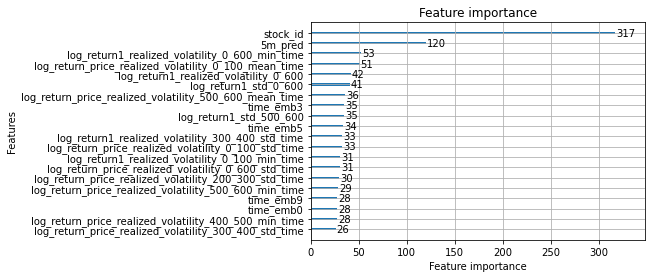

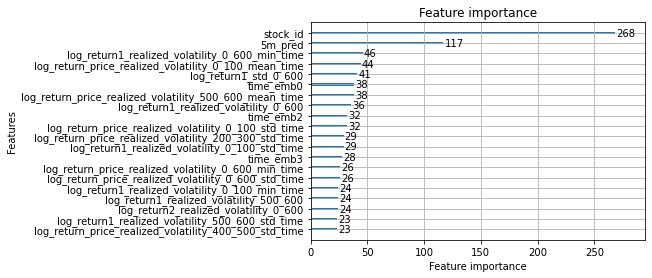

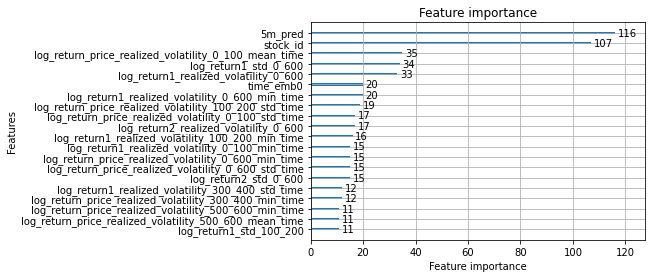

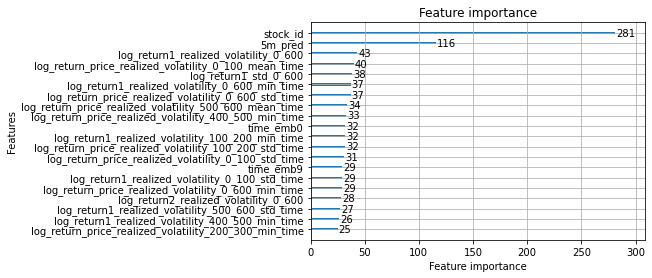

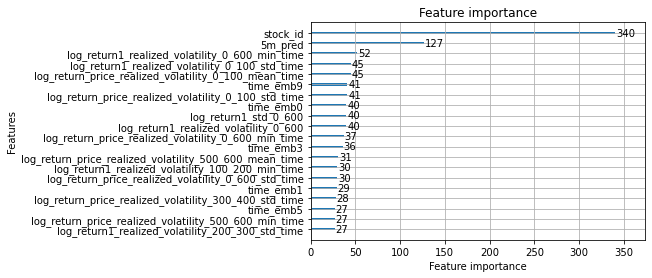

In [97]:
for m in models:
    lgb.plot_importance(m, max_num_features=20)